## Infiltration-01

Using analytical model for non-reactive transport from Wexler, 1989

In [1]:
from scipy.special import erfc as erfc
from scipy.special import erf as erf
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.interpolate import interp1d

In [2]:
# Length
x = 11.1 #14.69  

# Groundwater concentration
Cgw = 1.1 #1.220
# Vadose zone water 
Cvzw = Cgw*2.2
# River water (inf) concentration
Crw = Cgw*2 #0.009

# Time [days]
t = np.linspace(0, 500, num=5000) 
t1 = 100
t2 = 103.5 #6.66
t3 = 108.8
t_eff1 = np.maximum(t - t1, 1e-10)  # Effective time 1
t_eff2 = np.maximum(t - t2, 1e-10)  # Effective time 2
t_eff3 = np.maximum(t - t3, 1e-10)  # Effective time 3

time_lag = 100 
t_shifted = t - time_lag  # Shift the model time array

# Velocity [ft/d]
v = 1
# Mechanical dispersion 
alpha = 1.5
# Dispersion coefficient [ft^2/d] = alpha*v + D* [D* molecular diffusion]
D = v * alpha

In [3]:
Cvzw, Crw, D

(2.4200000000000004, 2.2, 1.5)

In [4]:
# Analytical solution (Wexler, 1989)
def ADE_type1_fun(x, t, t_eff1, t_eff2, t_eff3, v, D, Cgw, Cvzw, Crw):
    # Avoid division by zero
    t = np.maximum(t, 1e-10)
    
    # Analytical solution
    C = Cgw * (0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t))) +
              0.5 * np.exp(v * x / D) * erfc((x + v * t) / (2 * np.sqrt(D * t)))) + \
        (Cvzw - Cgw) * (0.5 * erfc((x - v * t_eff1) / (2 * np.sqrt(D * t_eff1))) +
                     0.5 * np.exp(v * x / D) * erfc((x + v * t_eff1) / (2 * np.sqrt(D * t_eff1)))) + \
        (Crw - Cvzw) * (0.5 * erfc((x - v * t_eff2) / (2 * np.sqrt(D * t_eff2))) +
                     0.5 * np.exp(v * x / D) * erfc((x + v * t_eff2) / (2 * np.sqrt(D * t_eff2)))) + \
        (Cgw - Crw) * (0.5 * erfc((x - v * t_eff3) / (2 * np.sqrt(D * t_eff3))) +
                     0.5 * np.exp(v * x / D) * erfc((x + v * t_eff3) / (2 * np.sqrt(D * t_eff3))))
    return C

In [5]:
# Call the function to calculate model data
Conc_time_type1 = ADE_type1_fun(x, t, t_eff1, t_eff2, t_eff3, v, D, Cgw, Cvzw, Crw)

In [6]:
# Save model output to a CSV file
output_data = pd.DataFrame({'Time (days)': t_shifted, 'Concentration (mg/L)': Conc_time_type1})
output_csv_file = './output/AM-01-w1005-U-output.csv'  
output_data.to_csv(output_csv_file, index=False)
print(f"Model output saved to {output_csv_file}")

Model output saved to ./output/AM-01-w1005-U-output.csv


In [7]:
# Read CSV file
csv_file = "../../data/AM-01_data/infil-01-AM-01_data.csv"  
data = pd.read_csv(csv_file)

# Extract specific columns from the CSV file
time_column = "Time_W1005"  
concentration_column = "U_W1005"  

time_data = data[time_column][0:51]
concentration_data = data[concentration_column][0:51]

In [8]:
print(data.columns)

Index(['Time_W1001', 'Br_W1001', 'DFB_W1001', 'U_W1001', 'Cl_W1001',
       'Unnamed: 5', 'Time_W1005', 'Br_W1005', 'DFB_W1005', 'U_W1005',
       'Cl_W1005', 'Unnamed: 11', 'Time_W1011', 'Br_W1011', 'DFB_W1011',
       'U_W1011', 'Cl_W1011'],
      dtype='object')


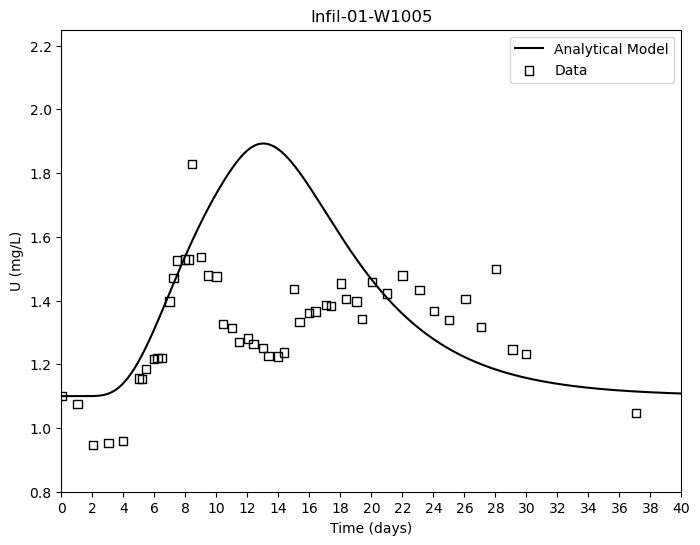

In [9]:
# Plot both model and data
plt.figure(figsize=(8, 6))  
plt.plot(t_shifted, Conc_time_type1, label='Analytical Model', color='black')
plt.scatter(time_data, concentration_data, label='Data', color='black', marker='s', facecolors='none')  # Scatter plot for data
plt.xlabel('Time (days)')
plt.ylabel('U (mg/L)')
plt.title('Infil-01-W1005')
plt.legend()

plt.xlim(0, 40) 
plt.ylim(0.8, 2.25)
plt.xticks(np.arange(0, 41, 2))  

plt.savefig('../img/AM-01-inf01-w1005-U.png', dpi=500) #fix img name base on parameters used
plt.show()

In [10]:
model_interpolated = np.interp(time_data, t_shifted, Conc_time_type1)
rmse = np.sqrt(mean_squared_error(concentration_data, model_interpolated))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 0.3010


In [11]:
# Add 10% to the concentration values (upper bound) and subtract 10% (lower bound)
Conc_upper = Conc_time_type1 * 1.10  # Increase by 10%
Conc_lower = Conc_time_type1 * 0.90  # Decrease by 10%

# Add these columns to the output data
output_data['Concentration Upper (mg/L)'] = Conc_upper
output_data['Concentration Lower (mg/L)'] = Conc_lower

# Save updated model output to a CSV file
output_csv_file_with_uncertainty = './output/AM-01-w1005-U-output-with-uncertainty.csv'
output_data.to_csv(output_csv_file_with_uncertainty, index=False)
print(f"Model output with uncertainty saved to {output_csv_file_with_uncertainty}")

Model output with uncertainty saved to ./output/AM-01-w1005-U-output-with-uncertainty.csv


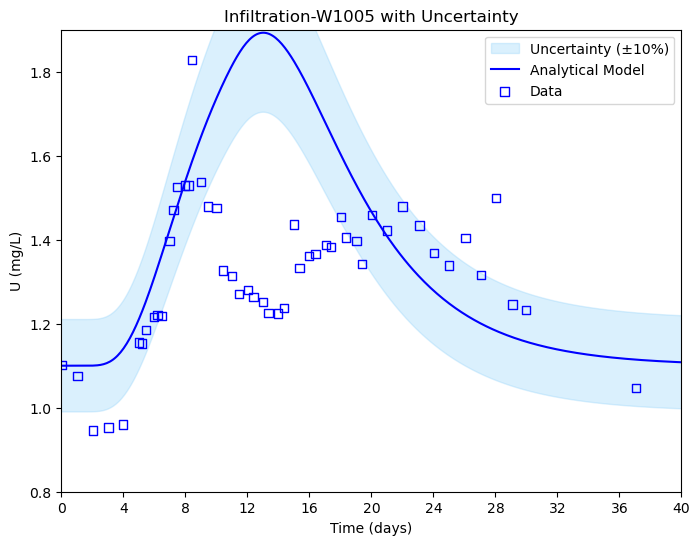

In [12]:
# Plot both model and data with uncertainty range
plt.figure(figsize=(8, 6))

# Plot the filled uncertainty range
plt.fill_between(t_shifted, Conc_lower, Conc_upper, color='lightskyblue', alpha=0.3, label='Uncertainty (±10%)')

# Plot the model concentration
plt.plot(t_shifted, Conc_time_type1, label='Analytical Model', color='blue')

# Scatter plot for data
plt.scatter(time_data, concentration_data, label='Data', color='blue', marker='s', facecolors='none')

# Add labels, title, and legend
plt.xlabel('Time (days)')
plt.ylabel('U (mg/L)')
plt.title('Infiltration-W1005 with Uncertainty')
plt.legend()

# Set limits and ticks for the x-axis and y-axis
plt.xlim(0, 40)
plt.ylim(0.8, 1.9)
plt.xticks(np.arange(0, 41, 4))

# Save the plot with uncertainty
#plt.savefig('../img/AM-01-inf01-w1005-U-unc.png', dpi=500) #fix img name base on parameters used
plt.show()